<a href="https://colab.research.google.com/github/IzaakGagnon/Integrated_Information_Testing/blob/main/Discrete_Estimator_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U "git+https://github.com/wmayner/pyphi.git@feature/update-packaging#egg=pyphi[parallel]"

import numpy as np
import pyphi
import random
import time
pyphi.config.PROGRESS_BARS = False
pyphi.config.SHORTCIRCUIT_SIA = False
pyphi.config.WELCOME_OFF = True
pyphi.config.REPERTOIRE_DISTANCE = "GENERALIZED_INTRINSIC_DIFFERENCE"
pyphi.config.PARALLEL = False
from scipy.stats import t
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.integrate import cumtrapz
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.stats.sampling import NumericalInverseHermite

DEPRECATION: git+https://github.com/wmayner/pyphi.git@feature/update-packaging#egg=pyphi[parallel] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://github.com/wmayner/pyphi.git (to revision feature/update-packaging) to /tmp/pip-install-ic_u50mf/pyphi_c8711e6f18f54a8a96646d8a0d4182a5
  Running command git clone --filter=blob:none --quiet https://github.com/wmayner/pyphi.git /tmp/pip-install-ic_u50mf/pyphi_c8711e6f18f54a8a96646d8a0d4182a5
  Running command git checkout -b feature/update-packaging --track origin/feature/update-packaging
  Switched to a new branch 'feature/update-packaging'
  Branch 'feature/update-packaging' set up to track remote branch 'feature/update-packaging' from 'origin'.
  Resolved https://github.com/wmayner/pyphi.git to commit 7a4e23808ddffa00cd393257a

In [2]:
### KDE Work:


from abc import get_cache_token
from pyphi.new_big_phi import *
import matplotlib.pyplot as plt
import functools
import itertools
from itertools import chain, product
import numpy as np
from more_itertools import distinct_permutations
from toolz import unique
from pyphi import combinatorics
from pyphi.cache import cache
from pyphi.conf import config, fallback
from pyphi.direction import Direction
from pyphi.models.cuts import (
    Bipartition,
    CompleteGeneralKCut,
    CompleteGeneralSetPartition,
    Cut,
    GeneralKCut,
    GeneralSetPartition,
    KPartition,
    Part,
    SystemPartition,
    Tripartition,)
from pyphi.partition import system_partition_types
from pyphi.registry import Registry
from itertools import combinations




@system_partition_types.register("K-PARTITIONS")
def _unidirectional_set_partitions2(node_indices, node_labels=None):
    """Generate all unidirectional set partitions of a set of nodes."""


    ### The Trivial Cut: No Partitions Made
    if len(node_indices) == 1 or config.SYSTEM_PARTITION_INCLUDE_COMPLETE:
        yield CompleteGeneralSetPartition(node_indices, node_labels=node_labels)



    _node_indices = set(range(len(node_indices)))

    for partition in combinatorics.set_partitions(_node_indices, nontrivial=True):
        for directions in product(Direction.all(), repeat=len(partition)):
            if Direction.CAUSE in directions and Direction.EFFECT in directions:

                ### Fill out cut Matrix for a partition-direction grouping
              cut_matrix = np.zeros([len(_node_indices), len(_node_indices)], dtype=int)
              for part, direction in zip(partition, directions):
                  nonpart = list(_node_indices - set(part))
                  if direction == Direction.CAUSE:
                      source, target = nonpart, part
                  else:
                      source, target = part, nonpart
                  cut_matrix[np.ix_(source, target)] = 1
                  if direction == Direction.BIDIRECTIONAL:
                      cut_matrix[np.ix_(target, source)] = 1


               ### Yield all the cuts
              yield GeneralSetPartition(
                  node_indices,
                  cut_matrix,
                  node_labels=node_labels,
                  set_partition=partition)

              ### Yield the cut ignored by the if (both directions in set)
    yield GeneralSetPartition(
                node_indices,
                np.ones(     (len(_node_indices), len(_node_indices))) - np.identity(len(_node_indices)),
                node_labels=node_labels,
                set_partition=partition,
            )

### Full Implementation Of The Faster Bi-Partition Algorithm
@system_partition_types.register("BI-PARTITIONS")
def generate_all_bipartitions(node_indices, node_labels=None):


  ### Perform the trivial cut
  if len(node_indices) == 1 or config.SYSTEM_PARTITION_INCLUDE_COMPLETE:
        yield CompleteGeneralSetPartition(node_indices, node_labels=node_labels)

  _node_indices = set(range(len(node_indices)))


  ### Loop through the possible partitions of the network.
  for partition in get_bipartitions(_node_indices):
      for directions in product(Direction.all(), repeat=len(partition)):
            if Direction.CAUSE in directions and Direction.EFFECT in directions:

              ### Fill out cut Matrix for a partition-direction grouping
              cut_matrix = np.zeros([len(_node_indices), len(_node_indices)], dtype=int)
              for part, direction in zip(partition, directions):

                  nonpart = list(_node_indices - set(part))



                  if direction == Direction.CAUSE:
                      source, target = nonpart, part
                  else:
                      source, target = part, nonpart
                  cut_matrix[np.ix_(source, target)] = 1
                  if direction == Direction.BIDIRECTIONAL:
                      cut_matrix[np.ix_(target, source)] = 1



                    ### Yield all the cuts
              yield GeneralSetPartition(
                  node_indices,
                  cut_matrix,
                  node_labels=node_labels,
                  set_partition=partition,
              )



              ### Yield the cut ignored by the if (both directions in set)
  yield GeneralSetPartition(
                node_indices,
                np.ones((len(_node_indices), len(_node_indices))) - np.identity(len(_node_indices)),
                node_labels=node_labels,
                set_partition=partition,
            )


def generate_restricted_bipartitions(node_indices, node_labels=None):
    directions = [True, False]
    """Generate all unidirectional set partitions of a set of nodes."""

    # Trivial Cut
    if len(node_indices) == 1 or config.SYSTEM_PARTITION_INCLUDE_COMPLETE:
        yield CompleteGeneralSetPartition(node_indices, node_labels=node_labels)


    _node_indices = set(range(len(node_indices)))
    for partition in get_bipartitions(_node_indices):
        for direction_seq in product(directions, repeat=len(partition)):

            # Fill out cut matrix
            cut_matrix = np.zeros([len(_node_indices), len(_node_indices)], dtype=int)
            for part, direction in zip(partition, direction_seq):
                nonpart = list(_node_indices - set(part))
                if direction:
                    source, target = nonpart, part
                else:
                    source, target = part, nonpart
                cut_matrix[np.ix_(source, target)] = 1


                # yield partition
            yield GeneralSetPartition(
                node_indices,
                cut_matrix,
                node_labels=node_labels,
                set_partition=partition,
            )


# Only do unique ones- ignores the very last one
@system_partition_types.register("UNIDIRECTIONAL_BIPARTITIONS")
@functools.wraps(generate_restricted_bipartitions)
def unidirectional_set_bipartitions(node_indices, node_labels=None):
    # TODO(4.0) generate properly without using set
    yield from unique(
        generate_restricted_bipartitions(node_indices, node_labels=node_labels)
    )


def get_phi_distribution(network, state):
  subsystem = pyphi.Subsystem(network,state)
  distribution = []

  def _has_no_cause_or_effect(system_state):
    reasons = []
    for direction, reason in zip(
        Direction.both(),
        [ShortCircuitConditions.NO_CAUSE, ShortCircuitConditions.NO_EFFECT],
    ):
        if system_state[direction].intrinsic_information <= 0:
            reasons.append(reason)
    return reasons
  def sia_return_all_cuts(
    subsystem: Subsystem,
    repertoire_distance: Optional[str] = None,
    directions: Optional[Iterable[Direction]] = None,
    partition_scheme: Optional[str] = None,
    partitions: Optional[Iterable] = None,
    system_state: Optional[SystemStateSpecification] = None,
    **kwargs,
    ) -> SystemIrreducibilityAnalysis:
    """Find the minimum information partition of a system."""
    partition_scheme = fallback(partition_scheme, config.SYSTEM_PARTITION_TYPE)

    # TODO(4.0): trivial reducibility

    if partitions is None:
        filter_func = None
        if partitions == "GENERAL":

            def is_disconnecting_partition(partition):
                # Special case for length 1 subsystems so complete partition is included
                return (
                    not connectivity.is_strong(subsystem.apply_cut(partition).proper_cm)
                ) or len(subsystem) == 1

            filter_func = is_disconnecting_partition

        partitions = system_partitions(
            subsystem.node_indices,
            node_labels=subsystem.node_labels,
            partition_scheme=partition_scheme,
            filter_func=filter_func,
        )

    if system_state is None:
        system_state = system_intrinsic_information(
            subsystem, directions=directions
        )

    def _null_sia(**kwargs):
        return NullSystemIrreducibilityAnalysis(
            system_state=system_state,
            node_indices=subsystem.node_indices,
            node_labels=subsystem.node_labels,
            **kwargs,
        )

    if config.SHORTCIRCUIT_SIA:
        shortcircuit_reasons = _has_no_cause_or_effect(system_state)
        if shortcircuit_reasons:
            return _null_sia(reasons=shortcircuit_reasons)

    default_sia = _null_sia(reasons=[ShortCircuitConditions.NO_VALID_PARTITIONS])

    parallel_kwargs = conf.parallel_kwargs(config.PARALLEL_CUT_EVALUATION, **kwargs)
    sias = MapReduce(
        evaluate_partition,
        partitions,
        map_kwargs=dict(
            subsystem=subsystem,
            system_state=system_state,
            repertoire_distance=repertoire_distance,
            directions=directions,
        ),
        shortcircuit_func=utils.is_falsy,
        desc="Evaluating partitions",
        **parallel_kwargs,
    ).run()

    # Find MIP in one pass, keeping track of ties
    # TODO(ties) refactor into resolve_ties module
    mip_sia = default_sia
    mip_key = (float("inf"), float("-inf"))
    ties = [default_sia]
    for sia__ in sias:
        distribution.append(sia__.phi)
    if phi_dist :
      return distribution
    for candidate_mip_sia in sias:
        candidate_key = sia_minimization_key(candidate_mip_sia)
        if candidate_key < mip_key:
            mip_sia = candidate_mip_sia
            mip_key = candidate_key
            ties = [mip_sia]
        elif candidate_key == mip_key:
            ties.append(candidate_mip_sia)
    for tied_mip in ties:
        tied_mip.set_ties(ties)
    return mip_sia
  pyphi.new_big_phi.sia = sia_return_all_cuts
  subsystem.sia()
  return distribution


#### NORMALIZED PHI DISTRIBUTION FUNCTION #####

def get_normalized_phi_distribution(network, state):
  subsystem = pyphi.Subsystem(network,state)
  distribution = []

  def _has_no_cause_or_effect(system_state):
    reasons = []
    for direction, reason in zip(
        Direction.both(),
        [ShortCircuitConditions.NO_CAUSE, ShortCircuitConditions.NO_EFFECT],
    ):
        if system_state[direction].intrinsic_information <= 0:
            reasons.append(reason)
    return reasons

  def sia_return_all_cuts(
    subsystem: Subsystem,
    repertoire_distance: Optional[str] = None,
    directions: Optional[Iterable[Direction]] = None,
    partition_scheme: Optional[str] = None,
    partitions: Optional[Iterable] = None,
    system_state: Optional[SystemStateSpecification] = None,
    **kwargs,
    ) -> SystemIrreducibilityAnalysis:
    """Find the minimum information partition of a system."""
    partition_scheme = fallback(partition_scheme, config.SYSTEM_PARTITION_TYPE)

    # TODO(4.0): trivial reducibility

    if partitions is None:
        filter_func = None
        if partitions == "GENERAL":

            def is_disconnecting_partition(partition):
                # Special case for length 1 subsystems so complete partition is included
                return (
                    not connectivity.is_strong(subsystem.apply_cut(partition).proper_cm)
                ) or len(subsystem) == 1

            filter_func = is_disconnecting_partition

        partitions = system_partitions(
            subsystem.node_indices,
            node_labels=subsystem.node_labels,
            partition_scheme=partition_scheme,
            filter_func=filter_func,
        )

    if system_state is None:
        system_state = system_intrinsic_information(
            subsystem, directions=directions
        )

    def _null_sia(**kwargs):
        return NullSystemIrreducibilityAnalysis(
            system_state=system_state,
            node_indices=subsystem.node_indices,
            node_labels=subsystem.node_labels,
            **kwargs,
        )

    if config.SHORTCIRCUIT_SIA:
        shortcircuit_reasons = _has_no_cause_or_effect(system_state)
        if shortcircuit_reasons:
            return _null_sia(reasons=shortcircuit_reasons)

    default_sia = _null_sia(reasons=[ShortCircuitConditions.NO_VALID_PARTITIONS])

    parallel_kwargs = conf.parallel_kwargs(config.PARALLEL_CUT_EVALUATION, **kwargs)
    sias = MapReduce(
        evaluate_partition,
        partitions,
        map_kwargs=dict(
            subsystem=subsystem,
            system_state=system_state,
            repertoire_distance=repertoire_distance,
            directions=directions,
        ),
        shortcircuit_func=utils.is_falsy,
        desc="Evaluating partitions",
        **parallel_kwargs,
    ).run()

    # Find MIP in one pass, keeping track of ties
    # TODO(ties) refactor into resolve_ties module
    mip_sia = default_sia
    mip_key = (float("inf"), float("-inf"))
    ties = [default_sia]
    for sia__ in sias:
        distribution.append(sia__.normalized_phi)
    if phi_dist :
      return distribution
    for candidate_mip_sia in sias:
        candidate_key = sia_minimization_key(candidate_mip_sia)
        if candidate_key < mip_key:
            mip_sia = candidate_mip_sia
            mip_key = candidate_key
            ties = [mip_sia]
        elif candidate_key == mip_key:
            ties.append(candidate_mip_sia)
    for tied_mip in ties:
        tied_mip.set_ties(ties)
    return mip_sia
  pyphi.new_big_phi.sia = sia_return_all_cuts
  subsystem.sia()
  return distribution

def generate_restricted_partitions(node_indices, node_labels=None):
    """Generate all unidirectional set partitions of a set of nodes."""


    ### Trivial Cut
    if len(node_indices) == 1 or config.SYSTEM_PARTITION_INCLUDE_COMPLETE:
        yield CompleteGeneralSetPartition(node_indices, node_labels=node_labels)


    directions = [True, False]
    _node_indices = set(range(len(node_indices)))
    for partition in combinatorics.set_partitions(_node_indices, nontrivial=True):
        for direction_seq in product(directions, repeat=len(partition)):


            ### Fill out cut matrix
            cut_matrix = np.zeros([len(_node_indices), len(_node_indices)], dtype=int)
            for part, direction in zip(partition, direction_seq):
                nonpart = list(_node_indices - set(part))
                if direction:
                    source, target = nonpart, part
                else:
                    source, target = part, nonpart
                cut_matrix[np.ix_(source, target)] = 1


                ### Yield the cuts
            yield GeneralSetPartition(
                node_indices,
                cut_matrix,
                node_labels=node_labels,
                set_partition=partition,
            )


### Yield the unique partitions only
@system_partition_types.register("UNIDIRECTIONAL_PARTITIONS")
@functools.wraps(generate_restricted_partitions)
def unidirectional_set_partitions(node_indices, node_labels=None):
    # TODO(4.0) generate properly without using set
    yield from unique(
        generate_restricted_partitions(node_indices, node_labels=node_labels)
    )



### Generate All Possible Bi-Partitions Of A Set Of Nodes
def get_bipartitions(collection):
    collection = list(collection)
    n = len(collection)
    # Special case: no bipartitions possible if the collection has fewer than 2 elements
    if n < 2:
        return
    # Generate all combinations for the first subset of size from 1 to n-1
    for i in range(1, n):
        for first_subset in combinations(collection, i):
            second_subset = [item for item in collection if item not in first_subset]
            yield [list(first_subset), second_subset]






def create_noisy_network(size):
    ### Obtains a random network of nodes of a given size, directly ready for computing Phi.
    def normalize_rows(matrix):
        ### Scales probabilities in a matrix so that they satisfy conditional independence
        num_rows = matrix.shape[0]
        normalized_matrix = np.zeros_like(matrix)# Create an empty matrix of the same shape
        for i in range(num_rows):
            row = matrix[i, :]
            current_sum = np.sum(row)
            if current_sum > 0:
                scaling_factor = 1.0 / current_sum
                normalized_row = row * scaling_factor
                normalized_matrix[i, :] = normalized_row
            else: print("Zero_Sum_Error: Problem With Values Generated")
        return normalized_matrix


    return pyphi.Network(normalize_rows(pyphi.convert.state_by_node2state_by_state(np.random.rand(2**size,size))))




0.005113993911225131


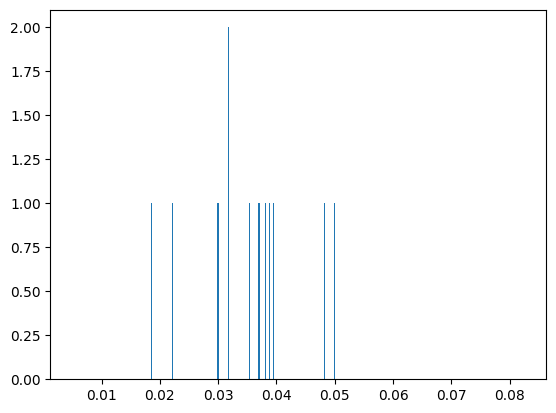

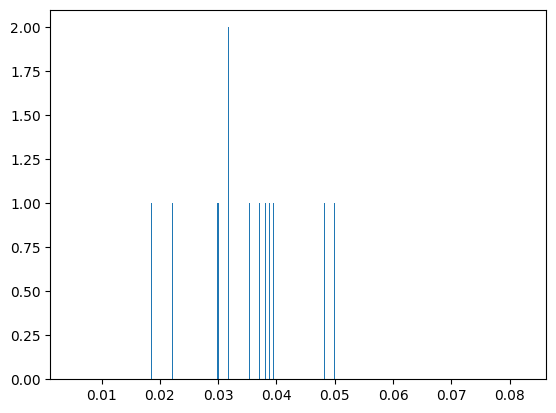

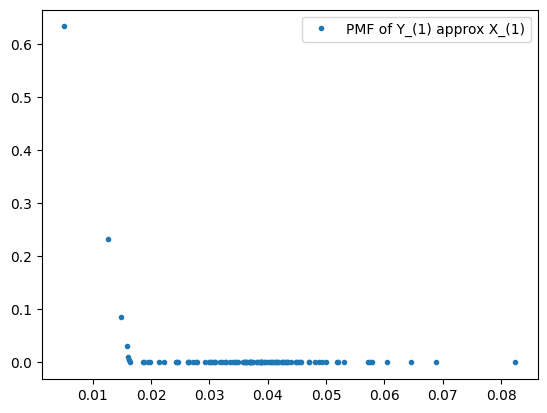

does it sum to 1?:  0.9999999999999999
expected value of first order st.: 0.008216964818263344


In [70]:
import numpy as np
import matplotlib.pyplot as plt
c=0
while c < 1:
  # Get Pyphi Network
  size = 4
  state = [np.random.choice([0,1]) for i in range(size)]
  network = create_noisy_network(size)
  subsystem = pyphi.Subsystem(network,state)
  phi_dist =  True
  normalized_phi_vals = get_normalized_phi_distribution(network, state)
  n= len(normalized_phi_vals)
  true_nphi= np.min(normalized_phi_vals)
  if true_nphi < 0.00000001:
    continue
  print(true_nphi)

  # Get Partition Data From network
  N = 100
  plt.hist(normalized_phi_vals, bins = 5000)
  plt.show()
  normalized_phi_vals = np.random.normal(loc = normalized_phi_vals, scale = 0.0000001)
  plt.hist(normalized_phi_vals, bins = 5000)
  plt.show()
  data = np.random.choice(normalized_phi_vals,N, replace=False)

  # Get First Order Statistic (Approximately)
  def pdf_x1(y):
    return ( N**(-N) * ( (N - sum(1 for i in data if i <= y) + 1)**N - ((N - sum(1 for i in data if i <= y))**N)    ))
  plt.plot(np.sort(data),[pdf_x1(y) for y in np.sort(data)],".", label = "PMF of Y_(1) approx X_(1)")
  plt.legend()
  plt.show()

  print("does it sum to 1?: ",np.sum([pdf_x1(y) for y in np.sort(data)]))
  print("expected value of first order st.:",np.sum([pdf_x1(y)*y for y in np.sort(data)]))
  c = c+1

0.016085986588935133


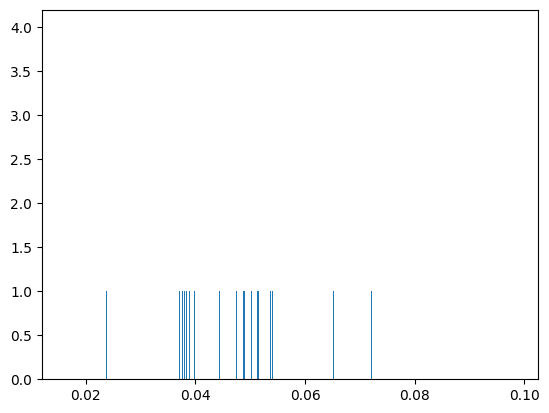

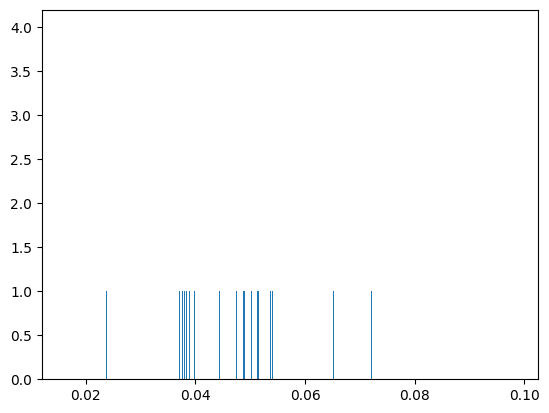

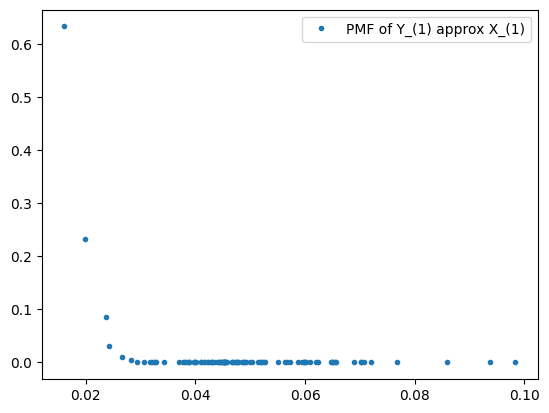

does it sum to 1?:  0.9999999999999999
expected value of first order st.: 0.01807953831350988
Unbiased Estimate For a: 0.012942686373913645
Actual a value: 0.016085986588935133
Minimum of sample: 0.01608614325703054


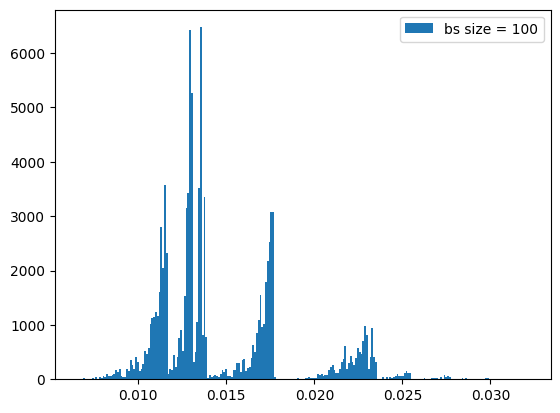

Percentile CI: [0.00983152 0.02332613]


In [93]:
### Simulation: A CI for a:

import numpy as np
import matplotlib.pyplot as plt
c=0
while c < 1:
  # Get Pyphi Network
  size = 4
  state = [np.random.choice([0,1]) for i in range(size)]
  network = create_noisy_network(size)
  subsystem = pyphi.Subsystem(network,state)
  phi_dist =  True
  normalized_phi_vals = get_normalized_phi_distribution(network, state)
  n= len(normalized_phi_vals)
  true_nphi= np.min(normalized_phi_vals)
  if true_nphi < 0.00000001:
    continue
  print(true_nphi)

  # Get Partition Data From network
  N = 100
  plt.hist(normalized_phi_vals, bins = 5000)
  plt.show()
  normalized_phi_vals = np.random.normal(loc = normalized_phi_vals, scale = 0.0000001)
  plt.hist(normalized_phi_vals, bins = 5000)
  plt.show()
  data = np.random.choice(normalized_phi_vals,N, replace=False)

  # Get First Order Statistic (Approximately)
  def pdf_x1(y):
    return ( N**(-N) * ( (N - sum(1 for i in data if i <= y) + 1)**N - ((N - sum(1 for i in data if i <= y))**N)    ))
  plt.plot(np.sort(data),[pdf_x1(y) for y in np.sort(data)],".", label = "PMF of Y_(1) approx X_(1)")
  plt.legend()
  plt.show()

  print("does it sum to 1?: ",np.sum([pdf_x1(y) for y in np.sort(data)]))
  print("expected value of first order st.:",np.sum([pdf_x1(y)*y for y in np.sort(data)]))
  c = c+1




### Obtain Unbiased Estimate For a
def get_unbiased_minimum(data):
  sample_minimum_nphi = np.min(data)
  truncated_sample = data[data > sample_minimum_nphi]
  def ordered_adjusted_sum(array):
    N = len(array)
    sorted_array = np.sort(array)
    s = 0
    for i in range(2, N + 1):
      s = s + (sorted_array[i-2])*( (N**(-N))*((N - i + 1)**N - (N-i)**N ))
    return s
  return (sample_minimum_nphi - ordered_adjusted_sum(truncated_sample))/ (1 - ((len(data)-1)/len(data))**len(data))



### Now for the bootstrap
bs_values = []
bs_sample_size = 100
for B in range(10000):
  boot_sample = np.random.choice(data, size = bs_sample_size)
  bs_values.append(get_unbiased_minimum(boot_sample))
plt.hist(bs_values, bins = 250,  label = "bs size = 100")
plt.legend()
plt.show()


# Percentile method
lower_percentile = (100 - 95) / 2
upper_percentile = 100 - lower_percentile
percentile_ci = np.percentile(bs_values, [lower_percentile, upper_percentile])
print("Percentile CI:", percentile_ci)

In [102]:
### Monte Carlo Simulation of Above Work for Verification of CI:
suc = 0
trials = 1000
for net in range(10):
  suc = 0
  c = 0
  while c < 1:
    size = 4
    state = [np.random.choice([0,1]) for i in range(size)]
    network = create_noisy_network(size)
    subsystem = pyphi.Subsystem(network,state)
    phi_dist =  True
    normalized_phi_vals = get_normalized_phi_distribution(network, state)
    n= len(normalized_phi_vals)
    true_nphi= np.min(normalized_phi_vals)
    if true_nphi < 0.00000001:
      continue

    # Get Partition Data From network
    N = 100
    normalized_phi_vals = np.random.normal(loc = normalized_phi_vals, scale = 0.0000001)
    data = np.random.choice(normalized_phi_vals,N, replace=False)

    # Get First Order Statistic (Approximately)
    def pdf_x1(y):
      return ( N**(-N) * ( (N - sum(1 for i in data if i <= y) + 1)**N - ((N - sum(1 for i in data if i <= y))**N)    ))

    c = c + 1


  ### Obtain Unbiased Estimate For a
  def get_unbiased_minimum(data):
    sample_minimum_nphi = np.min(data)
    truncated_sample = data[data > sample_minimum_nphi]
    def ordered_adjusted_sum(array):
      N = len(array)
      sorted_array = np.sort(array)
      s = 0
      for i in range(2, N + 1):
        s = s + (sorted_array[i-2])*( (N**(-N))*((N - i + 1)**N - (N-i)**N ))
      return s
    return (sample_minimum_nphi - ordered_adjusted_sum(truncated_sample))/ (1 - ((len(data)-1)/len(data))**len(data))

  for trial in range(trials):
      ### Collect a new sample from the same network
      data = np.random.choice(normalized_phi_vals,N, replace=False)
      bs_values = []
      bs_sample_size = 100
      for B in range(100):
        boot_sample = np.random.choice(data, size = bs_sample_size)
        bs_values.append(get_unbiased_minimum(boot_sample))
      # Percentile method
      percentile_ci = np.percentile(bs_values, [2.5, 97.5])
      if percentile_ci[0] < true_nphi < percentile_ci[1]:
        suc = suc + 1

  print(suc/trials)



0.913
0.989
0.979
0.971
0.911
0.648
0.694
0.905
0.892
0.886
